## **Machine Learning Approach for Early Diagnosis of Type 2 Diabetes in the Spanish Adult Population**

MSc in Data Science, Universitat Oberta de Catalunya (UOC)

**Joana Llauradó Pont**, Master Student  
**Laia Carreté Muñoz**, Project Supervisor  
Laia Subirats, Coordinator Professor

---

### SECTION 1: DEVELOP AND TEST ML MODELS
Train different ML models to detect the likelihood of diabetes and compute evaluation metrics.

---

#### **INIT WORKING ENVIORNMENT:**

 Connect to google drive and import the necessary libraries. Load the data.

In [2]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!nvcc --version
# 1) Install cuml cull
#!pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com
# 2) restart run time
# 3) check we can load library
# from cuml.svm import SVC

# 4) Install CUDA Toolkit
!apt-get update
!apt-get install -y cuda-toolkit-11-8

# 5)
!pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com

# 6) insall fias for knn gpu
!pip install faiss-gpu

print("cuml is successfully installed!")
# ensure GPU use in conf
#  3) check we can load library
# from cuml.svm import SVC

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,196 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,555 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,517 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illino

In [4]:
# Import libraries
import time
import os

# data preprocesssing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# modells-algorithms
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC as SklearnSVC
import cupy as cp
from cuml.svm import SVC as CuMLSVC  #  GPU-accelerated SVC
import faiss # knn GPU
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# model saving
import joblib
import pickle # for faiss

# metrics evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support


# plotting
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/cupy/_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [5]:
# Define the path to save results and ensure it exsists, if not create it
results_dir = "/content/drive/MyDrive/TFM 2024/results"
os.makedirs(results_dir, exist_ok=True)

#### **DEFINE FUNCTIONS:**

In [7]:
def log_metrics_detailed(model_name, y_true, y_pred, y_proba, start_time):
    runtime = time.time() - start_time
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)

    # Precision, Recall, F1-Score per class, macro average, and weighted average
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    # Print metrics
    print(f"Model: {model_name}")
    print(f"Class 0 (Non-Diabetic):")
    print(f"  - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1-Score: {f1[0]:.4f}")
    print(f"Class 1 (Diabetic):")
    print(f"  - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1-Score: {f1[1]:.4f}")
    print(f"Macro Average:")
    print(f"  - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-Score: {f1_macro:.4f}")
    print(f"Weighted Average:")
    print(f"  - Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1-Score: {f1_weighted:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Runtime: {runtime:.2f} seconds\n")

    # Log metrics in a dictionary for DataFrame construction
    metrics_df.loc[len(metrics_df)] = {
        'Model': model_name,
        'Metric': 'Class 0 (Non-Diabetic)',
        'Precision': precision[0],
        'Recall': recall[0],
        'F1-Score': f1[0],
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'Runtime': runtime
    }
    metrics_df.loc[len(metrics_df)] = {
        'Model': model_name,
        'Metric': 'Class 1 (Diabetic)',
        'Precision': precision[1],
        'Recall': recall[1],
        'F1-Score': f1[1],
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'Runtime': runtime
    }
    metrics_df.loc[len(metrics_df)] = {
        'Model': model_name,
        'Metric': 'Macro Avg',
        'Precision': precision_macro,
        'Recall': recall_macro,
        'F1-Score': f1_macro,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'Runtime': runtime
    }
    metrics_df.loc[len(metrics_df)] = {
        'Model': model_name,
        'Metric': 'Weighted Avg',
        'Precision': precision_weighted,
        'Recall': recall_weighted,
        'F1-Score': f1_weighted,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'Runtime': runtime
    }

def save_faiss_index(index, save_path):
    """
    Save a FAISS index to the specified path.
    Automatically moves the GPU index back to CPU for compatibility.
    """
    faiss.write_index(faiss.index_gpu_to_cpu(index), save_path)
    print(f"FAISS index saved successfully to: {save_path}")

def load_faiss_index(load_path, gpu=True):
    """
    Load a FAISS index from the specified path.
    Optionally move the index to GPU.
    """
    index = faiss.read_index(load_path)
    if gpu:
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0, index)
        print("FAISS index loaded and moved to GPU.")
    else:
        print("FAISS index loaded on CPU.")
    return index


###**DATASETS**

We will built 3 differents datasets and we'll train the different ML models in each of these datasets

**1. Model Using Only the Latest Test:** We'll only take the most recent test  as may represent the participant's current health status and could be the most relevant for predicting their diagnosis. To do so we'll select only the latest test for each Prueba per participant, resulting in one row per test type per participant.

**2. Model with Aggregate Features:** We'll summarize all available tests for each participant in order to reduce redundancy and creating a single row per participant. To do so, we'll compute summary statistics (mean, max, min, etc.) across tests and use these features as predictors.

**3. Model Without Aggregating:** We'll also use the raw data so the model can learn from it directly, which could be beneficial for patterns that aggregate features might miss.

 **ALGORITHMS-MODELS**

 * **Linear Regression Model**
 * **Support Vector Machine**
 * **k-Nearest Neighbourhood**
 * **Gradient Bosting Machine**
 * **Random Forest**


In [35]:
# Load data
data = pd.read_table('/content/drive/MyDrive/TFM 2024/Dades/final_merged_data.csv', sep =",")
data.head()

,ID,symptoms,Fecha,Edad,Sexo,Prueba,Resultado,Rango_Inferior,Rango_Superior,diagnostic,Sexo_Mujer,Prueba_HDL-Colesterol,Prueba_Hb-Glicosilada,Prueba_LDL-Calculado,Prueba_Trigliceridos,diagnostic_non_diabetic
0,UOC00035209,"hiperlipidemia, sedentarismo",2020-12-22,54,Mujer,Colesterol,181.0,70.0,200,diabetic,1.0,0.0,0.0,0.0,0.0,0.0
1,UOC00035209,"hiperlipidemia, sedentarismo",2020-12-22,54,Mujer,HDL-Colesterol,65.0,40.0,60,diabetic,1.0,1.0,0.0,0.0,0.0,0.0
2,UOC00035209,"hiperlipidemia, sedentarismo",2020-12-22,54,Mujer,Hb-Glicosilada,7.6,3.5,6,diabetic,1.0,0.0,1.0,0.0,0.0,0.0
3,UOC00035209,"hiperlipidemia, sedentarismo",2020-12-22,54,Mujer,LDL-Calculado,90.0,0.0,100,diabetic,1.0,0.0,0.0,1.0,0.0,0.0
4,UOC00035209,"hiperlipidemia, sedentarismo",2020-12-22,54,Mujer,Trigliceridos,129.0,35.0,200,diabetic,1.0,0.0,0.0,0.0,1.0,0.0


### **LAST TEST MODEL**

##### **DATA PRE-PROCESSING**

In [17]:
# Keep only the latest test for each participant and Prueba
data_latest = data.sort_values(by=['ID', 'Prueba', 'Fecha']).groupby(['ID', 'Prueba']).tail(1)

# Define predictors and outcome
X_latest = data_latest[['Edad', 'Sexo', 'symptoms', 'Prueba', 'Resultado']]
y_latest = (data_latest['diagnostic'] == 'diabetic').astype(int) # Binary target: 1 = diabetic, 0 = non-diabetic

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Resultado', 'Edad']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Sexo', 'symptoms', 'Prueba'])
    ]
)

# Train-test split
X_train_latest, X_test_latest, y_train_latest, y_test_latest = train_test_split(X_latest, y_latest, test_size=0.2, random_state=42)

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train_latest)
X_test_processed = preprocessor.transform(X_test_latest)

In [18]:
# Example input data for Latest Test Model
example_latest = data.sort_values(by=['ID', 'Prueba', 'Fecha']).groupby(['ID', 'Prueba']).tail(1).head(5)
print("Example Data INPUT for Latest Test Model:")
print(example_latest[['ID', 'symptoms', 'Fecha', 'Edad', 'Sexo', 'Prueba', 'Resultado', 'Rango_Inferior', 'Rango_Superior']])

Example Data INPUT for Latest Test Model:
                  ID         symptoms       Fecha  Edad    Sexo  \
1176392  UOC00028388  sin diagnostico  2021-04-26    52  Hombre   
1176400  UOC00028388  sin diagnostico  2021-04-26    52  Hombre   
1176402  UOC00028388  sin diagnostico  2020-05-20    52  Hombre   
1176404  UOC00028388  sin diagnostico  2021-04-26    52  Hombre   
1176399  UOC00028388  sin diagnostico  2021-04-26    52  Hombre   

                 Prueba  Resultado  Rango_Inferior  Rango_Superior  
1176392      Colesterol      170.0            70.0             200  
1176400  HDL-Colesterol       77.0            40.0              60  
1176402  Hb-Glicosilada        5.0             3.5               6  
1176404   LDL-Calculado       76.0             0.0             100  
1176399   Trigliceridos       86.0            30.0             200  


##### **LOGISTIC REGRESSION (LR)**


In [19]:
# Metrics DataFrame
metrics_df = pd.DataFrame(columns=['Model', 'Metric', 'Precision', 'Recall', 'F1-Score', 'Accuracy', 'ROC-AUC', 'Runtime'])


In [20]:
# 1. Logistic Regression
latest_test_results = {}

# Logistic Regression
start_time = time.time()
model_lr_latest = LogisticRegression(max_iter=1000)
model_lr_latest.fit(X_train_processed, y_train_latest)
y_pred_lr_latest = model_lr_latest.predict(X_test_processed)
y_proba_lr_latest = model_lr_latest.predict_proba(X_test_processed)[:, 1]
latest_test_results["Logistic Regression"] = (y_test_latest, y_proba_lr_latest)
log_metrics_detailed("Logistic Regression (Latest Test)", y_test_latest, y_pred_lr_latest, y_proba_lr_latest, start_time)

# Save Logistic Regression model
joblib.dump(model_lr_latest, os.path.join(results_dir, "logistic_regression_latest_test.joblib"))

Model: Logistic Regression (Latest Test)
Class 0 (Non-Diabetic):
  - Precision: 0.8732, Recall: 0.9363, F1-Score: 0.9037
Class 1 (Diabetic):
  - Precision: 0.9367, Recall: 0.8740, F1-Score: 0.9043
Macro Average:
  - Precision: 0.9050, Recall: 0.9051, F1-Score: 0.9040
Weighted Average:
  - Precision: 0.9062, Recall: 0.9040, F1-Score: 0.9040
Accuracy: 0.9040
ROC-AUC: 0.9788
Runtime: 0.12 seconds



['/content/drive/MyDrive/TFM 2024/results/logistic_regression_latest_test.joblib']

##### **SUPPORT VECTOR MACHINE MODEL (SVM)**

In [21]:
# 2. Support Vector Machine (CPU)
start_time = time.time()
model_svc_latest = SklearnSVC(kernel='rbf', C=1, gamma='scale', probability=True)
model_svc_latest.fit(X_train_processed, y_train_latest)
y_pred_svc_latest = model_svc_latest.predict(X_test_processed)
y_proba_svc_latest = model_svc_latest.predict_proba(X_test_processed)[:, 1]
latest_test_results["SVM (CPU)"] = (y_test_latest, y_proba_svc_latest)
log_metrics_detailed("SVM (CPU - Latest Test)", y_test_latest, y_pred_svc_latest, y_proba_svc_latest, start_time)

joblib.dump(model_svc_latest, os.path.join(results_dir, "svm_cpu_latest_test.joblib"))

Model: SVM (CPU - Latest Test)
Class 0 (Non-Diabetic):
  - Precision: 0.8989, Recall: 0.9220, F1-Score: 0.9103
Class 1 (Diabetic):
  - Precision: 0.9259, Recall: 0.9039, F1-Score: 0.9148
Macro Average:
  - Precision: 0.9124, Recall: 0.9129, F1-Score: 0.9125
Weighted Average:
  - Precision: 0.9129, Recall: 0.9126, F1-Score: 0.9126
Accuracy: 0.9126
ROC-AUC: 0.9726
Runtime: 42.02 seconds



['/content/drive/MyDrive/TFM 2024/results/svm_cpu_latest_test.joblib']

##### **K-NEAREST NEIGHBOURHOOD MODEL (KNN)**

In [22]:
# 3. K-Nearest Neighbourhood for Latest Test
start_time = time.time()

# Convert data to float32 arrays
X_train_f32 = np.array(X_train_processed.todense(), dtype='float32') if hasattr(X_train_processed, "todense") else np.array(X_train_processed, dtype='float32')
X_test_f32 = np.array(X_test_processed.todense(), dtype='float32') if hasattr(X_test_processed, "todense") else np.array(X_test_processed, dtype='float32')

# Define FAISS resources and GPU index
dimension = X_train_f32.shape[1]
res = faiss.StandardGpuResources()
index = faiss.IndexFlatL2(dimension)
gpu_index_latest = faiss.index_cpu_to_gpu(res, 0, index)  # Use descriptive name

# Add training data to the GPU index
gpu_index_latest.add(X_train_f32)

# Perform k-NN search
distances, indices = gpu_index_latest.search(X_test_f32, k=5)
y_train_array = y_train_latest.to_numpy() if hasattr(y_train_latest, "to_numpy") else np.array(y_train_latest)

# Majority voting for classification
y_pred_faiss_latest = np.array([np.argmax(np.bincount(y_train_array[neighbor_indices])) for neighbor_indices in indices])
y_proba_faiss_latest = np.array([np.mean(y_train_array[neighbor_indices]) for neighbor_indices in indices])

# Log results
latest_test_results["Faiss k-NN"] = (y_test_latest, y_proba_faiss_latest)
log_metrics_detailed("Faiss k-NN (Latest Test)", y_test_latest, y_pred_faiss_latest, y_proba_faiss_latest, start_time)

# Save FAISS index
save_faiss_index(gpu_index_latest, os.path.join(results_dir, "faiss_knn_latest_test.index"))


Model: Faiss k-NN (Latest Test)
Class 0 (Non-Diabetic):
  - Precision: 0.8909, Recall: 0.9183, F1-Score: 0.9044
Class 1 (Diabetic):
  - Precision: 0.9221, Recall: 0.8958, F1-Score: 0.9087
Macro Average:
  - Precision: 0.9065, Recall: 0.9070, F1-Score: 0.9066
Weighted Average:
  - Precision: 0.9071, Recall: 0.9066, F1-Score: 0.9066
Accuracy: 0.9066
ROC-AUC: 0.9696
Runtime: 0.19 seconds

FAISS index saved successfully to: /content/drive/MyDrive/TFM 2024/results/faiss_knn_latest_test.index


##### **GRADIENT BOOSTING MACHINE MODEL (GBM)**

In [23]:
# 4. XGBoost
start_time = time.time()
xgb_latest = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_latest.fit(X_train_processed, y_train_latest)
y_pred_xgb_latest = xgb_latest.predict(X_test_processed)
y_proba_xgb_latest = xgb_latest.predict_proba(X_test_processed)[:, 1]
latest_test_results["XGBoost"] = (y_test_latest, y_proba_xgb_latest)
log_metrics_detailed("XGBoost (Latest Test)", y_test_latest, y_pred_xgb_latest, y_proba_xgb_latest, start_time)

joblib.dump(xgb_latest, os.path.join(results_dir, "xgboost_latest_test.pkl"))


Model: XGBoost (Latest Test)
Class 0 (Non-Diabetic):
  - Precision: 0.8914, Recall: 0.9502, F1-Score: 0.9199
Class 1 (Diabetic):
  - Precision: 0.9508, Recall: 0.8927, F1-Score: 0.9208
Macro Average:
  - Precision: 0.9211, Recall: 0.9214, F1-Score: 0.9203
Weighted Average:
  - Precision: 0.9222, Recall: 0.9204, F1-Score: 0.9204
Accuracy: 0.9204
ROC-AUC: 0.9840
Runtime: 0.20 seconds



['/content/drive/MyDrive/TFM 2024/results/xgboost_latest_test.pkl']

##### **RANDOM FOREST MODEL (RF)**

In [24]:
# 5. Random Forest
start_time = time.time()
rf_latest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_latest.fit(X_train_processed, y_train_latest)
y_pred_rf_latest = rf_latest.predict(X_test_processed)
y_proba_rf_latest = rf_latest.predict_proba(X_test_processed)[:, 1]
latest_test_results["Random Forest"] = (y_test_latest, y_proba_rf_latest)
log_metrics_detailed("Random Forest (Latest Test)", y_test_latest, y_pred_rf_latest, y_proba_rf_latest, start_time)

joblib.dump(rf_latest, os.path.join(results_dir, "random_forest_latest_test.joblib"))


Model: Random Forest (Latest Test)
Class 0 (Non-Diabetic):
  - Precision: 0.9255, Recall: 0.8963, F1-Score: 0.9107
Class 1 (Diabetic):
  - Precision: 0.9066, Recall: 0.9331, F1-Score: 0.9197
Macro Average:
  - Precision: 0.9161, Recall: 0.9147, F1-Score: 0.9152
Weighted Average:
  - Precision: 0.9157, Recall: 0.9154, F1-Score: 0.9154
Accuracy: 0.9154
ROC-AUC: 0.9819
Runtime: 0.99 seconds



['/content/drive/MyDrive/TFM 2024/results/random_forest_latest_test.joblib']

In [25]:
# Save metrics to CSV
metrics_df.to_csv('/content/drive/MyDrive/TFM 2024/results/metrics_last_test_all_models.csv', index=False)
print("Metrics for all models saved to 'metrics_all_models.csv'.")

Metrics for all models saved to 'metrics_all_models.csv'.


### **AGGREGATED FEATURES MODEL**

##### **DATA PRE-PROCESSING**

In [9]:
# Aggregated Features Approach
aggregated_results = {}

# Aggregate Features for Model by Prueba, ID, and Fecha
data_agg = data.groupby(['ID', 'Fecha', 'Prueba']).agg({
    'Resultado': ['mean', 'std', 'max', 'min'],  # Test-specific statistics
    'Edad': 'first',
    'Sexo': 'first',
    'symptoms': 'first',
    'diagnostic': 'first'
}).reset_index()

# Flatten MultiIndex column names in data_agg
data_agg.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in data_agg.columns]

# Expand each Prueba as separate features
pruebas = data['Prueba'].unique()
for prueba in pruebas:
    prueba_data = data[data['Prueba'] == prueba].groupby(['ID', 'Fecha']).agg({
        'Resultado': ['mean', 'std', 'max', 'min']
    }).reset_index()

    # Flatten MultiIndex column names in prueba_data
    prueba_data.columns = [
        col if isinstance(col, str) else f"{prueba}_{col[1]}" if col[1] else col[0]
        for col in prueba_data.columns
    ]

    # Merge test-specific features with aggregated data
    data_agg = data_agg.merge(prueba_data, on=['ID', 'Fecha'], how='left')

# Features and target (exclude generic 'Resultado_*' columns)
feature_columns = [
    col for col in data_agg.columns
    if col not in ['ID', 'Fecha', 'Prueba', 'diagnostic_first'] and not col.startswith("Resultado_")
]
X_agg = data_agg[feature_columns]
y_agg = (data_agg['diagnostic_first'] == 'diabetic').astype(int)

# Train-test split
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_agg, y_agg, test_size=0.2, random_state=42)

# Preprocessing
numerical_features = [
    col for col in feature_columns if col.endswith(('_mean', '_std', '_max', '_min', 'Edad_first'))
]
categorical_features = ['Sexo_first', 'symptoms_first']

preprocessor_agg = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Preprocess the data
X_train_processed = preprocessor_agg.fit_transform(X_train_agg)
joblib.dump(preprocessor_agg, "/content/drive/MyDrive/TFM 2024/results/preprocessor_agg.joblib")

X_test_processed = preprocessor_agg.transform(X_test_agg)

In [10]:
# Metrics DataFrame
metrics_df = pd.DataFrame(columns=['Model', 'Metric', 'Precision', 'Recall', 'F1-Score', 'Accuracy', 'ROC-AUC', 'Runtime'])

##### **LOGISTIC REGRESSION (LR)**


In [11]:
# 1. Logistic Regression
start_time = time.time()
model_lr_agg = LogisticRegression(max_iter=1000)
model_lr_agg.fit(X_train_processed, y_train_agg)
y_pred_lr_agg = model_lr_agg.predict(X_test_processed)
y_proba_lr_agg = model_lr_agg.predict_proba(X_test_processed)[:, 1]
aggregated_results["Logistic Regression"] = (y_test_agg, y_proba_lr_agg)
log_metrics_detailed("Logistic Regression (Aggregated)", y_test_agg, y_pred_lr_agg, y_proba_lr_agg, start_time)
joblib.dump(model_lr_agg, os.path.join(results_dir, "logistic_regression_agg_test.joblib"))



Model: Logistic Regression (Aggregated)
Class 0 (Non-Diabetic):
  - Precision: 0.9002, Recall: 0.9214, F1-Score: 0.9107
Class 1 (Diabetic):
  - Precision: 0.9544, Recall: 0.9416, F1-Score: 0.9479
Macro Average:
  - Precision: 0.9273, Recall: 0.9315, F1-Score: 0.9293
Weighted Average:
  - Precision: 0.9347, Recall: 0.9342, F1-Score: 0.9344
Accuracy: 0.9342
ROC-AUC: 0.9872
Runtime: 0.97 seconds



['/content/drive/MyDrive/TFM 2024/results/logistic_regression_agg_test.joblib']

##### **SUPPORT VECTOR MACHINE MODEL (SVM)**

In [12]:
# 2. SVM (GPU)
start_time = time.time()
model_svc_agg = CuMLSVC(kernel='rbf', C=1, probability=True)
model_svc_agg.fit(X_train_processed, y_train_agg.to_numpy())
y_pred_svc_agg = model_svc_agg.predict(X_test_processed)
y_proba_svc_agg = model_svc_agg.predict_proba(X_test_processed)[:, 1]
aggregated_results["SVM (GPU)"] = (y_test_agg, y_proba_svc_agg)
log_metrics_detailed("SVM (GPU - Aggregated)", y_test_agg, y_pred_svc_agg, y_proba_svc_agg, start_time)
joblib.dump(model_svc_agg, os.path.join(results_dir, "svm_gpu_agg_test.joblib"))


Model: SVM (GPU - Aggregated)
Class 0 (Non-Diabetic):
  - Precision: 0.9186, Recall: 0.9385, F1-Score: 0.9285
Class 1 (Diabetic):
  - Precision: 0.9644, Recall: 0.9524, F1-Score: 0.9584
Macro Average:
  - Precision: 0.9415, Recall: 0.9455, F1-Score: 0.9434
Weighted Average:
  - Precision: 0.9477, Recall: 0.9474, F1-Score: 0.9475
Accuracy: 0.9474
ROC-AUC: 0.9888
Runtime: 13.80 seconds



['/content/drive/MyDrive/TFM 2024/results/svm_gpu_agg_test.joblib']

##### **K-NEAREST NEIGHBOURHOOD MODEL (KNN)**

In [13]:
start_time = time.time()

# Convert data to float32 arrays
X_train_f32 = np.array(X_train_processed.todense(), dtype='float32') if hasattr(X_train_processed, "todense") else np.array(X_train_processed, dtype='float32')
X_test_f32 = np.array(X_test_processed.todense(), dtype='float32') if hasattr(X_test_processed, "todense") else np.array(X_test_processed, dtype='float32')

# Define FAISS resources and GPU index
dimension = X_train_f32.shape[1]
res = faiss.StandardGpuResources()
index = faiss.IndexFlatL2(dimension)
gpu_index_agg = faiss.index_cpu_to_gpu(res, 0, index)  # Descriptive variable name for Aggregated Features

# Add training data to the GPU index
gpu_index_agg.add(X_train_f32)

# Perform k-NN search
distances, indices = gpu_index_agg.search(X_test_f32, k=5)
y_train_array = y_train_agg.to_numpy() if hasattr(y_train_agg, "to_numpy") else np.array(y_train_agg)

# Majority voting for classification
y_pred_faiss_agg = np.array([np.argmax(np.bincount(y_train_array[neighbor_indices])) for neighbor_indices in indices])
y_proba_faiss_agg = np.array([np.mean(y_train_array[neighbor_indices]) for neighbor_indices in indices])

# Log results
aggregated_results["Faiss k-NN"] = (y_test_agg, y_proba_faiss_agg)
log_metrics_detailed("Faiss k-NN (Aggregated Features)", y_test_agg, y_pred_faiss_agg, y_proba_faiss_agg, start_time)

# Save FAISS index
save_faiss_index(gpu_index_agg, os.path.join(results_dir, "faiss_knn_aggregated_features.index"))


Model: Faiss k-NN (Aggregated Features)
Class 0 (Non-Diabetic):
  - Precision: 0.9673, Recall: 0.9622, F1-Score: 0.9647
Class 1 (Diabetic):
  - Precision: 0.9784, Recall: 0.9814, F1-Score: 0.9799
Macro Average:
  - Precision: 0.9728, Recall: 0.9718, F1-Score: 0.9723
Weighted Average:
  - Precision: 0.9744, Recall: 0.9744, F1-Score: 0.9744
Accuracy: 0.9744
ROC-AUC: 0.9976
Runtime: 1.14 seconds

FAISS index saved successfully to: /content/drive/MyDrive/TFM 2024/results/faiss_knn_aggregated_features.index


##### **GRADIENT BOOSTING MACHINE MODEL (GBM)**

In [14]:
# 4. XGBoost
start_time = time.time()
xgb_agg = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_agg.fit(X_train_processed, y_train_agg)
y_pred_xgb_agg = xgb_agg.predict(X_test_processed)
y_proba_xgb_agg = xgb_agg.predict_proba(X_test_processed)[:, 1]
aggregated_results["XGBoost"] = (y_test_agg, y_proba_xgb_agg)
log_metrics_detailed("XGBoost (Aggregated)", y_test_agg, y_pred_xgb_agg, y_proba_xgb_agg, start_time)
joblib.dump(xgb_agg, os.path.join(results_dir, "xgboost_agg_test.pkl"))

Model: XGBoost (Aggregated)
Class 0 (Non-Diabetic):
  - Precision: 0.9438, Recall: 0.9703, F1-Score: 0.9569
Class 1 (Diabetic):
  - Precision: 0.9827, Recall: 0.9669, F1-Score: 0.9748
Macro Average:
  - Precision: 0.9633, Recall: 0.9686, F1-Score: 0.9658
Weighted Average:
  - Precision: 0.9685, Recall: 0.9682, F1-Score: 0.9682
Accuracy: 0.9682
ROC-AUC: 0.9961
Runtime: 0.85 seconds



['/content/drive/MyDrive/TFM 2024/results/xgboost_agg_test.pkl']

##### **RANDOM FOREST MODEL (RF)**

In [15]:
# 5. Random Forest
start_time = time.time()
rf_agg = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_agg.fit(X_train_processed, y_train_agg)
y_pred_rf_agg = rf_agg.predict(X_test_processed)
y_proba_rf_agg = rf_agg.predict_proba(X_test_processed)[:, 1]
aggregated_results["Random Forest"] = (y_test_agg, y_proba_rf_agg)
log_metrics_detailed("Random Forest (Aggregated)", y_test_agg, y_pred_rf_agg, y_proba_rf_agg, start_time)
joblib.dump(rf_agg, os.path.join(results_dir, "random_forest_agg_test.joblib"))




Model: Random Forest (Aggregated)
Class 0 (Non-Diabetic):
  - Precision: 0.9406, Recall: 0.9592, F1-Score: 0.9498
Class 1 (Diabetic):
  - Precision: 0.9764, Recall: 0.9653, F1-Score: 0.9708
Macro Average:
  - Precision: 0.9585, Recall: 0.9622, F1-Score: 0.9603
Weighted Average:
  - Precision: 0.9633, Recall: 0.9631, F1-Score: 0.9632
Accuracy: 0.9631
ROC-AUC: 0.9886
Runtime: 8.07 seconds



['/content/drive/MyDrive/TFM 2024/results/random_forest_agg_test.joblib']

In [16]:
# Save metrics to CSV
metrics_df.to_csv('/content/drive/MyDrive/TFM 2024/results/metrics_aggregated_features.csv', index=False)
print("Metrics for all models with aggregated features saved to 'metrics_aggregated_features.csv'.")

Metrics for all models with aggregated features saved to 'metrics_aggregated_features.csv'.


### **NON-AGGREGATED FEATURES MODEL**

In [26]:
# Non-Aggregated Features Approach
non_aggregated_results = {}

# Features and target for Non-Aggregated Model
X_no_agg = data[['Edad', 'Sexo', 'symptoms', 'Prueba', 'Resultado']]
y_no_agg = (data['diagnostic'] == 'diabetic').astype(int)  # Binary target: 1 = diabetic, 0 = non-diabetic

# Train-test split
X_train_no_agg, X_test_no_agg, y_train_no_agg, y_test_no_agg = train_test_split(X_no_agg, y_no_agg, test_size=0.2, random_state=42)

# Preprocessing
preprocessor_no_agg = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]),
         ['Resultado', 'Edad']),  # Numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Sexo', 'symptoms', 'Prueba'])  # Categorical features
    ]
)

# Preprocess the data
X_train_processed = preprocessor_no_agg.fit_transform(X_train_no_agg)
X_test_processed = preprocessor_no_agg.transform(X_test_no_agg)

In [27]:
# Metrics DataFrame
metrics_df = pd.DataFrame(columns=['Model', 'Metric', 'Precision', 'Recall', 'F1-Score', 'Accuracy', 'ROC-AUC', 'Runtime'])

##### **LOGISTIC REGRESSION (LR)**

In [28]:
# 1. Logistic Regression
start_time = time.time()
model_lr_no_agg = LogisticRegression(max_iter=1000)
model_lr_no_agg.fit(X_train_processed, y_train_no_agg)
y_pred_lr_no_agg = model_lr_no_agg.predict(X_test_processed)
y_proba_lr_no_agg = model_lr_no_agg.predict_proba(X_test_processed)[:, 1]
non_aggregated_results["Logistic Regression"] = (y_test_no_agg, y_proba_lr_no_agg)
log_metrics_detailed("Logistic Regression (Non-Aggregated)", y_test_no_agg, y_pred_lr_no_agg, y_proba_lr_no_agg, start_time)
joblib.dump(model_lr_no_agg, os.path.join(results_dir, "logistic_regression_no_agg_test.joblib"))

Model: Logistic Regression (Non-Aggregated)
Class 0 (Non-Diabetic):
  - Precision: 0.8957, Recall: 0.8073, F1-Score: 0.8492
Class 1 (Diabetic):
  - Precision: 0.9234, Recall: 0.9611, F1-Score: 0.9419
Macro Average:
  - Precision: 0.9096, Recall: 0.8842, F1-Score: 0.8956
Weighted Average:
  - Precision: 0.9153, Recall: 0.9161, F1-Score: 0.9148
Accuracy: 0.9161
ROC-AUC: 0.9769
Runtime: 2.76 seconds



['/content/drive/MyDrive/TFM 2024/results/logistic_regression_no_agg_test.joblib']

#####  **SUPPORT VECTOR MACHINE MODEL (SVM)**



In [29]:
# 2. CuML SVM (GPU)
start_time = time.time()
model_svc_no_agg = CuMLSVC(kernel='rbf', C=1, probability=True)  # Use CuML SVM
model_svc_no_agg.fit(X_train_processed, y_train_no_agg.to_numpy())  # Convert y_train to NumPy array
y_pred_svc_no_agg = model_svc_no_agg.predict(X_test_processed)
y_proba_svc_no_agg = model_svc_no_agg.predict_proba(X_test_processed)[:, 1]
non_aggregated_results["SVM (GPU)"] = (y_test_no_agg, y_proba_svc_no_agg)
log_metrics_detailed("SVM (GPU - Non-Aggregated)", y_test_no_agg, y_pred_svc_no_agg, y_proba_svc_no_agg, start_time)
joblib.dump(model_svc_no_agg, os.path.join(results_dir, "svm_gpu_no_agg_test.joblib"))


Model: SVM (GPU - Non-Aggregated)
Class 0 (Non-Diabetic):
  - Precision: 0.9062, Recall: 0.8313, F1-Score: 0.8671
Class 1 (Diabetic):
  - Precision: 0.9325, Recall: 0.9644, F1-Score: 0.9482
Macro Average:
  - Precision: 0.9194, Recall: 0.8978, F1-Score: 0.9077
Weighted Average:
  - Precision: 0.9248, Recall: 0.9254, F1-Score: 0.9245
Accuracy: 0.9254
ROC-AUC: 0.9811
Runtime: 2714.36 seconds



['/content/drive/MyDrive/TFM 2024/results/svm_gpu_no_agg_test.joblib']

##### **K-NEAREST NEIGHBOURHOOD MODEL (KNN)**



In [30]:
# 3. Faiss k-NN

start_time = time.time()

# Convert data to float32 arrays
X_train_f32 = np.array(X_train_processed.todense(), dtype='float32') if hasattr(X_train_processed, "todense") else np.array(X_train_processed, dtype='float32')
X_test_f32 = np.array(X_test_processed.todense(), dtype='float32') if hasattr(X_test_processed, "todense") else np.array(X_test_processed, dtype='float32')

# Define FAISS resources and GPU index
dimension = X_train_f32.shape[1]
res = faiss.StandardGpuResources()
index = faiss.IndexFlatL2(dimension)
gpu_index_no_agg = faiss.index_cpu_to_gpu(res, 0, index)  # Descriptive variable name for Non-Aggregated Features

# Add training data to the GPU index
gpu_index_no_agg.add(X_train_f32)

# Perform k-NN search
distances, indices = gpu_index_no_agg.search(X_test_f32, k=5)
y_train_array = y_train_no_agg.to_numpy() if hasattr(y_train_no_agg, "to_numpy") else np.array(y_train_no_agg)

# Majority voting for classification
y_pred_faiss_no_agg = np.array([np.argmax(np.bincount(y_train_array[neighbor_indices])) for neighbor_indices in indices])
y_proba_faiss_no_agg = np.array([np.mean(y_train_array[neighbor_indices]) for neighbor_indices in indices])

# Log results
non_aggregated_results["Faiss k-NN"] = (y_test_no_agg, y_proba_faiss_no_agg)
log_metrics_detailed("Faiss k-NN (Non-Aggregated Features)", y_test_no_agg, y_pred_faiss_no_agg, y_proba_faiss_no_agg, start_time)

# Save FAISS index
save_faiss_index(gpu_index_no_agg, os.path.join(results_dir, "faiss_knn_non_aggregated_features.index"))


Model: Faiss k-NN (Non-Aggregated Features)
Class 0 (Non-Diabetic):
  - Precision: 0.9890, Recall: 0.9846, F1-Score: 0.9868
Class 1 (Diabetic):
  - Precision: 0.9937, Recall: 0.9955, F1-Score: 0.9946
Macro Average:
  - Precision: 0.9913, Recall: 0.9900, F1-Score: 0.9907
Weighted Average:
  - Precision: 0.9923, Recall: 0.9923, F1-Score: 0.9923
Accuracy: 0.9923
ROC-AUC: 0.9987
Runtime: 29.84 seconds

FAISS index saved successfully to: /content/drive/MyDrive/TFM 2024/results/faiss_knn_non_aggregated_features.index


##### **GRADIENT BOOSTING MACHINE MODEL (GBM)**

In [31]:
# 4. XGBoost
start_time = time.time()
xgb_no_agg = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_no_agg.fit(X_train_processed, y_train_no_agg)
y_pred_xgb_no_agg = xgb_no_agg.predict(X_test_processed)
y_proba_xgb_no_agg = xgb_no_agg.predict_proba(X_test_processed)[:, 1]
non_aggregated_results["XGBoost"] = (y_test_no_agg, y_proba_xgb_no_agg)
log_metrics_detailed("XGBoost (Non-Aggregated)", y_test_no_agg, y_pred_xgb_no_agg, y_proba_xgb_no_agg, start_time)
joblib.dump(xgb_no_agg, os.path.join(results_dir, "xgboost_no_agg_test.pkl"))

Model: XGBoost (Non-Aggregated)
Class 0 (Non-Diabetic):
  - Precision: 0.9156, Recall: 0.8570, F1-Score: 0.8853
Class 1 (Diabetic):
  - Precision: 0.9423, Recall: 0.9673, F1-Score: 0.9547
Macro Average:
  - Precision: 0.9290, Recall: 0.9121, F1-Score: 0.9200
Weighted Average:
  - Precision: 0.9345, Recall: 0.9350, F1-Score: 0.9344
Accuracy: 0.9350
ROC-AUC: 0.9849
Runtime: 15.79 seconds



['/content/drive/MyDrive/TFM 2024/results/xgboost_no_agg_test.pkl']

##### **RANDOM FOREST MODEL (RF)**

In [32]:
# 5. Random Forest
start_time = time.time()
rf_no_agg = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_no_agg.fit(X_train_processed, y_train_no_agg)
y_pred_rf_no_agg = rf_no_agg.predict(X_test_processed)
y_proba_rf_no_agg = rf_no_agg.predict_proba(X_test_processed)[:, 1]
non_aggregated_results["Random Forest"] = (y_test_no_agg, y_proba_rf_no_agg)
log_metrics_detailed("Random Forest (Non-Aggregated)", y_test_no_agg, y_pred_rf_no_agg, y_proba_rf_no_agg, start_time)
joblib.dump(rf_no_agg, os.path.join(results_dir, "random_forest_no_agg_test.joblib"))

Model: Random Forest (Non-Aggregated)
Class 0 (Non-Diabetic):
  - Precision: 0.9707, Recall: 0.7445, F1-Score: 0.8427
Class 1 (Diabetic):
  - Precision: 0.9036, Recall: 0.9907, F1-Score: 0.9451
Macro Average:
  - Precision: 0.9371, Recall: 0.8676, F1-Score: 0.8939
Weighted Average:
  - Precision: 0.9232, Recall: 0.9186, F1-Score: 0.9151
Accuracy: 0.9186
ROC-AUC: 0.9827
Runtime: 123.71 seconds



['/content/drive/MyDrive/TFM 2024/results/random_forest_no_agg_test.joblib']

In [33]:
# Save metrics to CSV
metrics_df.to_csv('/content/drive/MyDrive/TFM 2024/results/metrics_non_aggregated_features.csv', index=False)
print("Metrics for all models with non-aggregated features saved to 'metrics_non_aggregated_features.csv'.")

Metrics for all models with non-aggregated features saved to 'metrics_non_aggregated_features.csv'.


### **TABLE SUPORTS**

In [ ]:
# Calculate support (number of samples) for each dataset
# No Aggregation Model
support_no_agg = data['diagnostic'].value_counts().to_dict()

# Latest Test Model
support_latest = data_latest['diagnostic'].value_counts().to_dict()

# Aggregated Features Model
support_agg = data_agg['diagnostic_first'].value_counts().to_dict()

# Combine support values into a single table
support_table = pd.DataFrame({
    "Model": ["No Aggregation Model", "Latest Test Model", "Aggregated Features Model"],
    "Diabetic": [
        support_no_agg.get('diabetic', 0),
        support_latest.get('diabetic', 0),
        support_agg.get('diabetic', 0),
    ],
    "Non-Diabetic": [
        support_no_agg.get('non_diabetic', 0),
        support_latest.get('non_diabetic', 0),
        support_agg.get('non_diabetic', 0),
    ],
    "Total": [
        len(data),
        len(data_latest),
        len(data_agg),
    ]
})


In [ ]:
# Calculate train-test split proportions
train_ratio = 0.8

# No Aggregation Model
train_samples_no_agg = int(len(data) * train_ratio)
test_samples_no_agg = len(data) - train_samples_no_agg

train_support_no_agg = data.iloc[:train_samples_no_agg]['diagnostic'].value_counts().to_dict()
test_support_no_agg = data.iloc[train_samples_no_agg:]['diagnostic'].value_counts().to_dict()

# Latest Test Model
train_samples_latest = int(len(data_latest) * train_ratio)
test_samples_latest = len(data_latest) - train_samples_latest

train_support_latest = data_latest.iloc[:train_samples_latest]['diagnostic'].value_counts().to_dict()
test_support_latest = data_latest.iloc[train_samples_latest:]['diagnostic'].value_counts().to_dict()

# Aggregated Features Model
train_samples_agg = int(len(data_agg) * train_ratio)
test_samples_agg = len(data_agg) - train_samples_agg

train_support_agg = data_agg.iloc[:train_samples_agg]['diagnostic_first'].value_counts().to_dict()
test_support_agg = data_agg.iloc[train_samples_agg:]['diagnostic_first'].value_counts().to_dict()

# Create the support table split by train and test
support_table_split = pd.DataFrame({
    "Model": ["No Aggregation Model", "Latest Test Model", "Aggregated Features Model"],
    "Train Diabetic": [
        train_support_no_agg.get('diabetic', 0),
        train_support_latest.get('diabetic', 0),
        train_support_agg.get('diabetic', 0),
    ],
    "Train Non-Diabetic": [
        train_support_no_agg.get('non_diabetic', 0),
        train_support_latest.get('non_diabetic', 0),
        train_support_agg.get('non_diabetic', 0),
    ],
    "Test Diabetic": [
        test_support_no_agg.get('diabetic', 0),
        test_support_latest.get('diabetic', 0),
        test_support_agg.get('diabetic', 0),
    ],
    "Test Non-Diabetic": [
        test_support_no_agg.get('non_diabetic', 0),
        test_support_latest.get('non_diabetic', 0),
        test_support_agg.get('non_diabetic', 0),
    ],
    "Total": [
        len(data),
        len(data_latest),
        len(data_agg),
    ]
})


### **PLOTS**

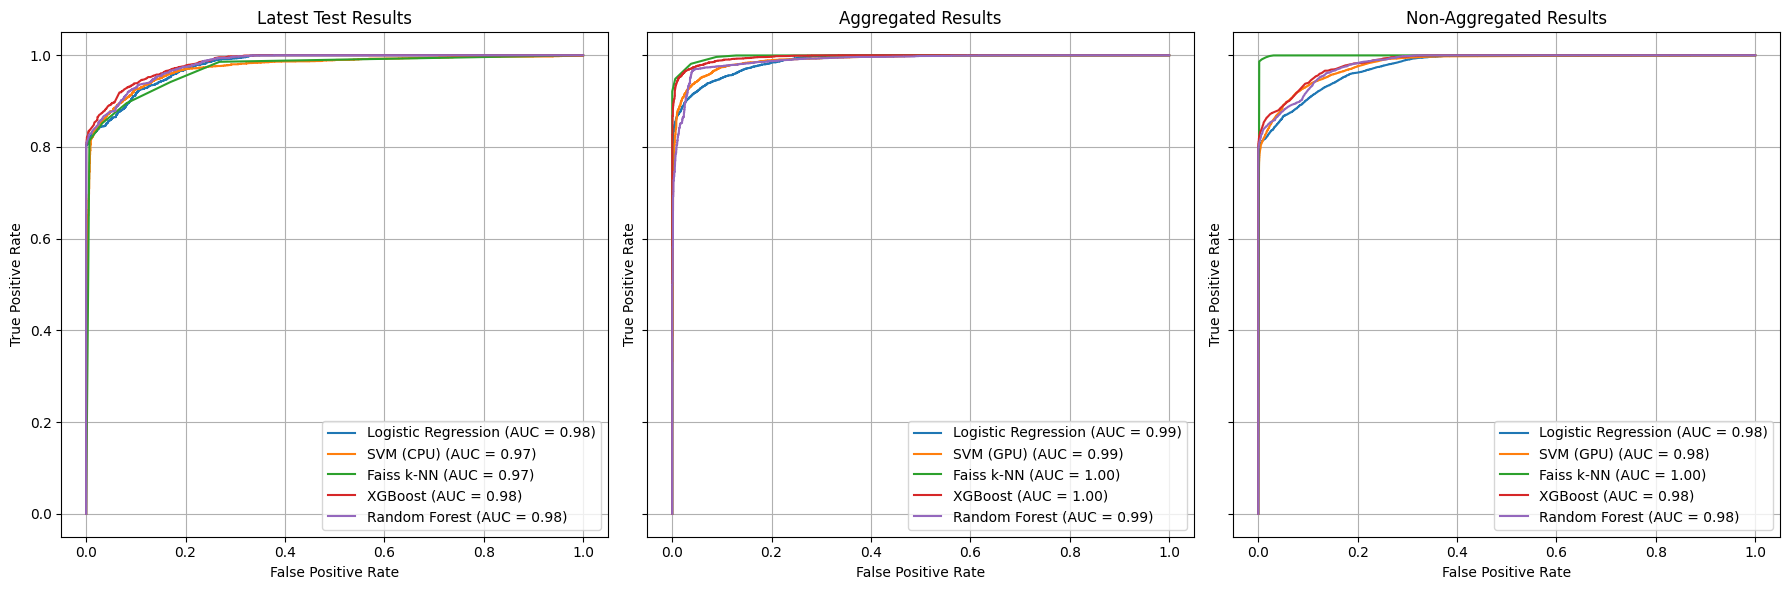

In [50]:
# Define the datasets
datasets = {
    "Latest Test Results": latest_test_results,
    "Aggregated Results": aggregated_results,
    "Non-Aggregated Results": non_aggregated_results
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Iterate over datasets and corresponding axes
for ax, (title, results) in zip(axes, datasets.items()):
    for model_name, (true_labels, predicted_probs) in results.items():
        fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
        auc_score = roc_auc_score(true_labels, predicted_probs)
        ax.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

    ax.set_title(title)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Save
plot_filename = "/content/drive/MyDrive/TFM 2024/results/roc_curves_by_model_and_approach.png"
fig.savefig(plot_filename, dpi=300)  # Save with high resolution

